### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

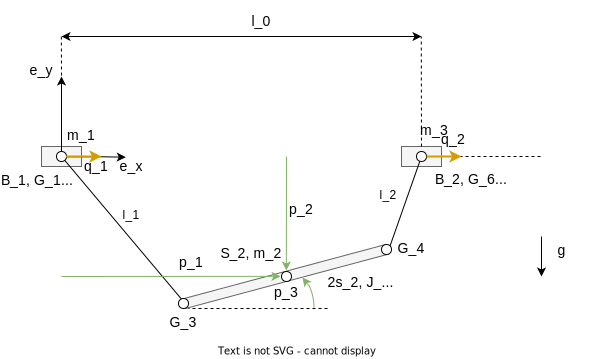

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_simulation_diagram.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates (not directly actuated)
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(4+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

aa.T := [a₁  a₂  a₃  a₄]

---

ttheta.T := [p₁  p₂  p₃  q₁  q₂]

---

tthetad.T := [ṗ₁  ṗ₂  ṗ₃  q̇₁  q̇₂]

---

tthetadd.T := [p̈₁  p̈₂  p̈₃  q̈₁  q̈₂]

---

tthetaddd.T := [p⃛₁  p⃛₂  p⃛₃  q⃛₁  q⃛₂]

---

tthetadddd.T := [p⃜₁  p⃜₂  p⃜₃  q⃜₁  q⃜₂]

---

QQ.T := [Q₁  Q₂  Q₃  Q₄  Q₅]

---

In [4]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")


Specify the geometry (joints G and centers of masses S)

In [5]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G6 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])

# suspension points of load
G3 = S2 - Rz(p3)*ex*s2 ##:
G4 = S2 + Rz(p3)*ex*s2 ##:

# Time derivatives of centers of masses
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta)) ##:

B1 := ⎡q₁⎤
⎢  ⎥
⎣0 ⎦

---

B2 := ⎡l₀ + q₂⎤
⎢       ⎥
⎣   0   ⎦

---

G3 := ⎡p₁ - s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ - s₂⋅sin(p₃)⎦

---

G4 := ⎡p₁ + s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ + s₂⋅sin(p₃)⎦

---

(Sd1, Sd2, Sd3) := ⎛⎡q̇₁⎤  ⎡ṗ₁⎤  ⎡q̇₂⎤⎞
⎜⎢  ⎥, ⎢  ⎥, ⎢  ⎥⎟
⎝⎣0 ⎦  ⎣ṗ₂⎦  ⎣0 ⎦⎠

---

this model is very easy ...

In [6]:
F1 = sp.Matrix([tau1, 0])  ##:T
F2 = sp.Matrix([tau2, 0])  ##:T

# unit vectors for ropes to split forces according to angles
rope1 = (G3 - S1)
rope2 = (G4 - S3)
uv_rope1 = rope1/sp.sqrt((rope1.T*rope1)[0])
uv_rope2 = rope2/sp.sqrt((rope2.T*rope2)[0])

# simplify expressions by using l1, l2 as shortcuts 
uv_rope1 = rope1/l1
uv_rope2 = rope2/l2

F3 = uv_rope1 * tau3 ##:
F4 = uv_rope2 * tau4 ##:

F1.T := [τ₁  0]

---

F2.T := [τ₂  0]

---

F3 := ⎡τ₃⋅(p₁ - q₁ - s₂⋅cos(p₃))⎤
⎢─────────────────────────⎥
⎢            l₁           ⎥
⎢                         ⎥
⎢  τ₃⋅(p₂ - s₂⋅sin(p₃))   ⎥
⎢  ────────────────────   ⎥
⎣           l₁            ⎦

---

F4 := ⎡τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))⎤
⎢───────────────────────────────⎥
⎢               l₂              ⎥
⎢                               ⎥
⎢     τ₄⋅(p₂ + s₂⋅sin(p₃))      ⎥
⎢     ────────────────────      ⎥
⎣              l₂               ⎦

---

#### Quasistatic state feedback control

In [7]:
# load model etc. from pickle of flatness analysis notebook
with open("flatness_analysis_control.pcl", "rb") as pfile:
    mod, eqns, ttau, flat_q2, flat_qddot2, flat_tau1, flat_tau2, flat_tau3, flat_tau4, flat_tau1_control, flat_tau2_control, flat_tau3_control, flat_tau4_control = pickle.load(pfile)

In [8]:
flat_tau1.s ##:
flat_tau2.s ##:
flat_tau3.s ##:
flat_tau4.s ##:

---

---

---

---

Nonlinearities are chosen to be the new inputs of the system:
\begin{align}
    v_1 &:= \ddot{p}_1 = \ddot{y}_1 \\
    v_2 &:= \ddot{p}_2 = \ddot{y}_2 \\
    v_3 &:= \ddot{p}_3 = \ddot{y}_3 \\
    v_4 &:= \ddot{q}_1 = \ddot{y}_4 
\end{align}

In [9]:
ttaud = st.time_deriv(ttau, ttau)
ttaudd = st.time_deriv(ttau, ttau, order=2)

st.make_global(ttaud, ttaudd)

In [10]:
xx_ext = sp.Matrix(len(mod.xx)+2*len(mod.tau), 1, [*mod.xx, *ttau, *ttaud])
fg_ext = sp.Matrix(len(mod.state_eq)+2*len(mod.tau), 1, [*mod.state_eq, *ttaud, *ttaudd])

In [11]:
y1_ext = xx_ext[0]
ydot1_ext = st.lie_deriv(y1_ext, fg_ext, xx_ext)
yddot1_ext = st.lie_deriv(ydot1_ext, fg_ext, xx_ext)
ydddot1_ext = st.lie_deriv(yddot1_ext, fg_ext, xx_ext)
yddddot1_ext = st.lie_deriv(ydddot1_ext, fg_ext, xx_ext)

ydot1_ext.s ##:
yddot1_ext.s ##:
ydddot1_ext.s ##:
yddddot1_ext.s ##:

---

---

---

---

In [12]:
y2_ext = xx_ext[1]
ydot2_ext = st.lie_deriv(y2_ext, fg_ext, xx_ext)
yddot2_ext = st.lie_deriv(ydot2_ext, fg_ext, xx_ext)
ydddot2_ext = st.lie_deriv(yddot2_ext, fg_ext, xx_ext)
yddddot2_ext = st.lie_deriv(ydddot2_ext, fg_ext, xx_ext)

ydot2_ext.s ##:
yddot2_ext.s ##:
ydddot2_ext.s ##:
yddddot2_ext.s ##:

---

---

---

---

In [13]:
y3_ext = xx_ext[2]
ydot3_ext = st.lie_deriv(y3_ext, fg_ext, xx_ext)
yddot3_ext = st.lie_deriv(ydot3_ext, fg_ext, xx_ext)
ydddot3_ext = st.lie_deriv(yddot3_ext, fg_ext, xx_ext)
yddddot3_ext = st.lie_deriv(ydddot3_ext, fg_ext, xx_ext)

ydot3_ext.s ##:
yddot3_ext.s ##:
ydddot3_ext.s ##:
yddddot3_ext.s ##:

---

---

---

---

In [14]:
y4_ext = xx_ext[3]
ydot4_ext = st.lie_deriv(y4_ext, fg_ext, xx_ext)
yddot4_ext = st.lie_deriv(ydot4_ext, fg_ext, xx_ext)
ydddot4_ext = st.lie_deriv(yddot4_ext, fg_ext, xx_ext)
yddddot4_ext = st.lie_deriv(ydddot4_ext, fg_ext, xx_ext)

ydot4_ext.s ##:
yddot4_ext.s ##:
ydddot4_ext.s ##:
yddddot4_ext.s ##:

---

---

---

---

#### State feedback for control

In [49]:
# define error symbols
p_error = st.symb_vector("pe1:{0}".format(3+1)) # error vector of passive coordinates
q_error = st.symb_vector("qe1:{0}".format(2+1)) # error vector of actuated coordinates
v_inputs = st.symb_vector("v1:{0}".format(4+1)) # vector of new inputs

error_states = st.row_stack(p_error, q_error)
error_states_d = st.time_deriv(error_states, error_states)
error_states_dd = st.time_deriv(error_states, error_states, order=2)
error_states_ddd = st.time_deriv(error_states, error_states, order=3)
error_states_dddd = st.time_deriv(error_states, error_states, order=4)

st.make_global(error_states, error_states_d, error_states_dd, error_states_ddd, error_states_dddd)

# define symbols for measured states
p_meas = st.symb_vector("pm1:{0}".format(3+1)) # error vector of passive coordinates
q_meas = st.symb_vector("qm1:{0}".format(2+1)) # error vector of actuated coordinates

meas_states = st.row_stack(p_meas, q_meas)
meas_states_d = st.time_deriv(meas_states, meas_states)
meas_states_dd = st.time_deriv(meas_states, meas_states, order=2)
meas_states_ddd = st.time_deriv(meas_states, meas_states, order=3)
meas_states_dddd = st.time_deriv(meas_states, meas_states, order=4)

st.make_global(meas_states, meas_states_d, meas_states_dd, meas_states_ddd, meas_states_dddd)

# define symbols for reference trajectory states
p_ref = st.symb_vector("pr1:{0}".format(3+1)) # error vector of passive coordinates
q_ref = st.symb_vector("qr1:{0}".format(2+1)) # error vector of actuated coordinates

ref_states = st.row_stack(p_ref, q_ref)
ref_states_d = st.time_deriv(ref_states, ref_states)
ref_states_dd = st.time_deriv(ref_states, ref_states, order=2)
ref_states_ddd = st.time_deriv(ref_states, ref_states, order=3)
ref_states_dddd = st.time_deriv(ref_states, ref_states, order=4)

st.make_global(ref_states, ref_states_d, ref_states_dd, ref_states_ddd, ref_states_dddd)

v_inputs_d = st.time_deriv(v_inputs, v_inputs)
v_inputs_dd = st.time_deriv(v_inputs, v_inputs, order=2)
st.make_global(v_inputs, v_inputs_d, v_inputs_dd)

#### Linear feedback error:
$$
e := y - y_{\text{ref}}
$$

#### Error dynamics:
$$
e^{(n)} + c_{n-1} e^{(n-1)} + ... + c_{1} \dot{e} + c_{0} e = 0 
\Leftrightarrow y^{(n)} = y_{\text{ref}}^{(n)} - c_{n-1} e^{(n-1)} - ... - c_{1} \dot{e} - c_{0} e
$$

In [53]:
# coefficients for error dynamics
# Polynome: s^2 + c_i[1] s + c_i[0] s
cp1 = [1, 2]
cp2 = [1, 2]
cp3 = [100, 20]
cq1 = [1, 2]
c2 = sp.Matrix([cp1, cp2, cp3, cq1, [0, 0]])

Every component of the flat output $\mathbf{y}$ appearing in $\mathbf{\tau}$ with a higher order derivative than 1 has to be substituted, becaus it is assumed that only positions and speeds of $\mathbf{y}$ can be measured directly.

##### Quasi static state feedback:
\begin{align}
    \ddot{e} + c_1 \dot{e} + c_0 e &= 0 \\
    e^{(3)} + c_1 \ddot{e} + c_0 \dot{e} &= 0 \\
    e^{(3)} + c_1 (-c_1 \dot{e} - c_0 e) + c_0 dot{e} &= 0 \\
    e^{(3)} - c_1^2 \dot{e} + c_0 \dot{e} - c_0 c_1 e &= 0 \\
    e^{(3)} + (c_0 - c_1^2) \dot{e} - c_0 c_1 e &= 0 \\
    e^{(4)} + (c_0 - c_1^2) \ddot{e} - c_0 c_1 \dot{e} &= 0 \\
    e^{(4)} + (c_0 - c_1^2) (-c_1 \dot{e} - c_0 e) - c_0 c_1 \dot{e} &= 0 \\
    e^{(4)} + (c_1^2 - 2 c_0 c_1) \dot{e} + (c_0 c_1^2 - c_0^2) e &= 0 \\
    \Rightarrow y^{(3)} &= y_{\text{ref}}^{(3)} - (c_0 - c_1^2) \dot{e} + c_0 c_1 e \\
    \Rightarrow y^{(4)} &= y_{\text{ref}}^{(4)} - (c_1^3 - 2 c_0 c_1) \dot{e} - (c_0 c_1^2 - c_0^2) e
\end{align}

In [54]:
from sympy.matrices.dense import matrix_multiply_elementwise as elmul

In [55]:
c2_00 = elmul(c2[:, 0], c2[:, 0])
c2_01 = elmul(c2[:, 0], c2[:, 1])
c2_11 = elmul(c2[:, 1], c2[:, 1])
c2_111 = elmul(elmul(c2[:, 1], c2[:, 1]), c2[:, 1])
c2_011 = elmul(elmul(c2[:, 0], c2[:, 1]), c2[:, 1])

In [56]:
meas_subs_dd = ref_states_dd - elmul(c2[:, 1], (meas_states_d - ref_states_d)) - elmul(c2[:, 0], (meas_states - ref_states)) ##:

meas_subs_dd := ⎡     -pm₁ - 2⋅pṁ₁ + pr₁ + pr̈₁ + 2⋅pṙ₁     ⎤
⎢                                          ⎥
⎢     -pm₂ - 2⋅pṁ₂ + pr₂ + pr̈₂ + 2⋅pṙ₂     ⎥
⎢                                          ⎥
⎢-100⋅pm₃ - 20⋅pṁ₃ + 100⋅pr₃ + pr̈₃ + 20⋅pṙ₃⎥
⎢                                          ⎥
⎢     -qm₁ - 2⋅qṁ₁ + qr₁ + qr̈₁ + 2⋅qṙ₁     ⎥
⎢                                          ⎥
⎣                   qr̈₂                    ⎦

---

In [78]:
# for quasi static state feedback approach
meas_subs_ddd = ref_states_ddd - elmul((c2[:, 0] - c2_11), (meas_states_d - ref_states_d)) + elmul(c2_01, (meas_states - ref_states))
meas_subs_dddd = ref_states_dddd - elmul((c2_111 - 2*c2_01), (meas_states_d - ref_states_d)) - elmul((c2_011 - c2_00), (meas_states - ref_states))

#### Inputs from flat output

In [79]:
sol_tau134 = sp.solve((v1-yddot1_ext, v3-yddot3_ext, v4-yddot4_ext), tau1, tau3, tau4)

In [80]:
tau1_alg = sol_tau134[tau1].smplf
tau3_alg = sol_tau134[tau3].smplf
tau4_alg = sol_tau134[tau4].smplf

In [81]:
tau1_alg.s ##:
tau3_alg.s ##:
tau4_alg.s ##:

---

---

---

In [82]:
tau1_alg = tau1_alg.subz([*tthetadd, *tthetad, *ttheta, v1, v3, v4], [*meas_states_dd, *meas_states_d, *meas_states, meas_subs_dd[0], meas_subs_dd[2], meas_subs_dd[3]])
tau1_alg = tau1_alg.subz([*ref_states_dd, *ref_states_d, *ref_states], [*tthetadd, *tthetad, *ttheta])
tau3_alg = tau3_alg.subz([*tthetadd, *tthetad, *ttheta, v1, v3], [*meas_states_dd, *meas_states_d, *meas_states, meas_subs_dd[0], meas_subs_dd[2]])
tau3_alg = tau3_alg.subz([*ref_states_dd, *ref_states_d, *ref_states], [*tthetadd, *tthetad, *ttheta])
tau4_alg = tau4_alg.subz([*tthetadd, *tthetad, *ttheta, v1, v3], [*meas_states_dd, *meas_states_d, *meas_states, meas_subs_dd[0], meas_subs_dd[2]])
tau4_alg = tau4_alg.subz([*ref_states_dd, *ref_states_d, *ref_states], [*tthetadd, *tthetad, *ttheta])

In [83]:
tau1_alg.s ##:
tau3_alg.s ##:
tau4_alg.s ##:

---

---

---

In [84]:
# store with pickle
pickle_data = [tau1_alg, tau3_alg, tau4_alg]

with open("quasistatic_control.pcl", "wb") as pfile:
    pickle.dump(pickle_data, pfile)

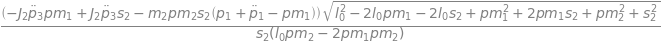

In [85]:
taudot3_alg = st.lie_deriv(tau3_alg, fg_ext, xx_ext, order=1)
tauddot3_alg = st.lie_deriv(taudot3_alg, fg_ext, xx_ext, order=1)
taudot4_alg = st.lie_deriv(tau4_alg, fg_ext, xx_ext, order=1)
tauddot4_alg = st.lie_deriv(taudot4_alg, fg_ext, xx_ext, order=1)

In [86]:
yddddot2_subs = yddddot2_ext.subz([tauddot3, tauddot4, taudot3, taudot4, tau1, tau3, tau4], [tauddot3_alg, tauddot4_alg, taudot3_alg, taudot4_alg, tau1_alg, tau3_alg, tau4_alg])

In [87]:
yddddot2_ext.s

In [88]:
c1 = yddddot2_subs.diff(tau2)
c0 = yddddot2_subs.subs(tau2, 0)

In [89]:
tau2_alg = (pddddot2 - c0)/c1
tau2_alg.s ##:

---

In [22]:
flat_qdot2 = st.time_deriv(flat_q2, ttheta)

In [23]:
tau1_alg = tau1_alg.subs(q2, flat_q2[0])
tau2_alg = tau2_alg.subz([qdot2, q2], [flat_qdot2[0], flat_q2[0]])
tau3_alg = tau3_alg.subs(q2, flat_q2[0])
tau4_alg = tau4_alg.subs(q2, flat_q2[0])

In [24]:
# store with pickle
pickle_data = [tau1_alg, tau2_alg, tau3_alg, tau4_alg]

with open("quasistatic_control.pcl", "wb") as pfile:
    pickle.dump(pickle_data, pfile)